<h1 align="center"><span style='font-family:arial'>Farm Relief Customer Segmentation Analysis</h1>

<h3 align="center"><span style='font-family:arial'>February 2023</h3>

# Overview

In this project, we will concentrate on Nigerian farmers who sell produce and their customers. We will investigate some of the group's demographic characteristics, such as age, income bracket, occupation, and so on. Then we'll choose features and build a clustering model to segment consumers into subgroups. Finally, we will create some visuals to highlight the distinctions between these subgroups.

The dataset used was extracted from the 'Farm Relief' Google Form. The form collects demographic, financial, and opinion data on individuals in Nigeria. The survey was launched under a month ago and is still open.

# Objective

The purpose of this research is to perform customer segmentation using unsupervised learning, specifically clustering.

We will:

    Compare characteristics across subgroups using a scatterplot chart.
    Conduct feature selection for clustering.
    Use KPrototypes to handle both the numerical and categorical data.
    Build a k-means clustering model.
    Reduce high-dimensional data using principal component analysis (PCA).

> Libraries

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Data Preparation

## Importing The File

In [2]:
farm = pd.read_csv('farm_relief.csv')
print("farm shape:", farm.shape)
farm.head()

farm shape: (59, 17)


Age range  Age  Gender            Occupation Marital status     Income  \
0       18 - 25   21  Female               Student          Single     #5000   
1       26 - 35   27  Female               Student         Married  #120,000   
2  50 and above   57    Male                Farmer         Married  #155,000   
3       18 - 25   23    Male               Student          Single   #15,000   
4       26 - 35   28    Male  Freelance copywriter          Single  #300,000   

  Monthly Household income Location e.g Lagos, Nigeria Device type  \
0                < #50,000                    Modakeke     Android   
1      #100,000 - #200,000                        Osun     Android   
2      #100,000 - #200,000                        Osun     Android   
3                < #50,000                       Ekiti     Android   
4      #200,000 - #500,000                      Ibadan     Android   

  Most preferred delivery method Are you a farmer?  \
0                  Home Delivery                No   
1                  Home Delivery                No   
2                  Home Delivery               Yes   
3                  Home Delivery                No   
4                  Home Delivery                No   

  If yes, What farming system do you have?  \
0                                      NaN   
1                                      NaN   
2                              Small Scale   
3                                      NaN   
4                                      NaN   

  What farm produce do you buy or sell? (You can give a list)  \
0             Garri\nRice\nPepper\nOnion\nVegetables            
1  Pepper, Vegetables, Plantain, Charcoal, Yam fl...            
2                                              Cocoa            
3                                    Vegetables,Rice            
4                                  Vegetables,Grains            

  Would you like an online platform where you can buy or sell farm products and not feel cheated?  \
0                                                Yes                                                
1                                                Yes                                                
2                                                Yes                                                
3                                                Yes                                                
4                                                Yes                                                

  Do you know of any platform that provides you with the service mentioned above?  \
0                                                 No                                
1                                                 No                                
2                                                 No                                
3                                              Maybe                                
4                                                 No                                

  If yes, please give a name  \
0                        NaN   
1                        NaN   
2                        NaN   
3                        NaN   
4                        NaN   

  What features would you be looking forward to on such a digital platform?  
0                                                NaN                         
1                           Prompt Response, Pricing                         
2                                        More Profit                         
3                                                NaN                         
4  Pricing, Friendly user interface, Impressive l...

## Data Cleaning

- Changing headers

In [3]:
farm.rename(columns={
    'Age range':'Age Range',
    'Marital status':'Marital Status',
    'Monthly Household income':'Monthly Household Income',
    'Location e.g Lagos, Nigeria':'Location',
    'Device type':'Device Type',
    'Most preferred delivery method':'Delivery Method',
    'Are you a farmer?':'Farmer',
    'If yes, What farming system do you have?':'Farming System',
    'What farm produce do you buy or sell? (You can give a list)':'Farm Produce',
    'Would you like an online platform where you can buy or sell farm products and not feel cheated?':'Online Platform',
    'Do you know of any platform that provides you with the service mentioned above?':'Alternative Platform Knowledge',
    'If yes, please give a name':'Platform Name',
    'What features would you be looking forward to on such a digital platform?':'Digital Platform Features',    
}, inplace=True)

- Making a copy of original DataFrame with amended column names

In [4]:
data = farm.copy()

In [5]:
# the amended DataFrame with headers
data.head(1)

Age Range  Age  Gender Occupation Marital status  Income  \
0   18 - 25   21  Female    Student          Single  #5000   

  Monthly Household Income  Location Device Type Delivery Method Farmer  \
0                < #50,000  Modakeke     Android   Home Delivery     No   

  Farming System                            Farm Produce Online Platform  \
0            NaN  Garri\nRice\nPepper\nOnion\nVegetables             Yes   

  Alternative Platform Knowledge Platform Name Digital Platform Features  
0                             No           NaN                       NaN

- Removing # and , from `Monthly Household Income` values

In [6]:
data['Monthly Household Income'] = (data['Monthly Household Income']
                   .str.replace('#','', regex=False)
                   .str.replace(',', '')
                   )

- Removing # and , from `Income` values and change data type to float

In [7]:
data['Income'] = (data['Income']
                   .str.replace('#','', regex=False)
                   .str.replace(',', '')
                   .astype(float)
                   )

- Replacing \n with space in the `Farm Produce`

In [8]:
data['Farm Produce'] = (data['Farm Produce']
                  .str.replace('\n',',', regex=False)
                  )

> Missing values percentage

In [9]:
data.isnull().sum()/len(data)

Age Range                         0.000000
Age                               0.000000
Gender                            0.000000
Occupation                        0.152542
Marital status                    0.000000
Income                            0.000000
Monthly Household Income          0.000000
Location                          0.000000
Device Type                       0.000000
Delivery Method                   0.000000
Farmer                            0.000000
Farming System                    0.661017
Farm Produce                      0.000000
Online Platform                   0.016949
Alternative Platform Knowledge    0.000000
Platform Name                     0.847458
Digital Platform Features         0.525424
dtype: float64

 **Occupation**, **Farming System**, **Online Platform**, **Platform Name** and **Digital Platform Features** columns have missing values.

- Removing features with a high null count i.e > 50%

In [10]:
data.drop(columns=['Farming System', 'Platform Name', 'Digital Platform Features'], inplace=True)

> information about the DataFrame

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age Range                       59 non-null     object 
 1   Age                             59 non-null     int64  
 2   Gender                          59 non-null     object 
 3   Occupation                      50 non-null     object 
 4   Marital status                  59 non-null     object 
 5   Income                          59 non-null     float64
 6   Monthly Household Income        59 non-null     object 
 7   Location                        59 non-null     object 
 8   Device Type                     59 non-null     object 
 9   Delivery Method                 59 non-null     object 
 10  Farmer                          59 non-null     object 
 11  Farm Produce                    59 non-null     object 
 12  Online Platform                 58 non

  - Filling in the NaN values with 'Not Specified'.

In [12]:
cols = ['Occupation', 'Online Platform']
data[cols] = data[cols].fillna('Not Specified')

In [13]:
# re check missing values
data.isnull().sum()

Age Range                         0
Age                               0
Gender                            0
Occupation                        0
Marital status                    0
Income                            0
Monthly Household Income          0
Location                          0
Device Type                       0
Delivery Method                   0
Farmer                            0
Farm Produce                      0
Online Platform                   0
Alternative Platform Knowledge    0
dtype: int64

- Saving cleaned data to csv

In [14]:
data.to_csv('farm_relief_clean.csv', index=False)

## Exploration

In [15]:
# setting the theme
sns.set_theme()
# for image quality of the graphics
sns.set(rc = {"figure.dpi":350})
# for size of the graphics
sns.set(rc = {"figure.figsize":(6,3)})

### Age

> The age groups present

In [16]:
# unique values of 'Age Range'
age_groups = data['Age Range'].unique()
print("Age Groups:", age_groups)

Age Groups: ['18 - 25' '26 - 35' '50 and above' '35 - 49']


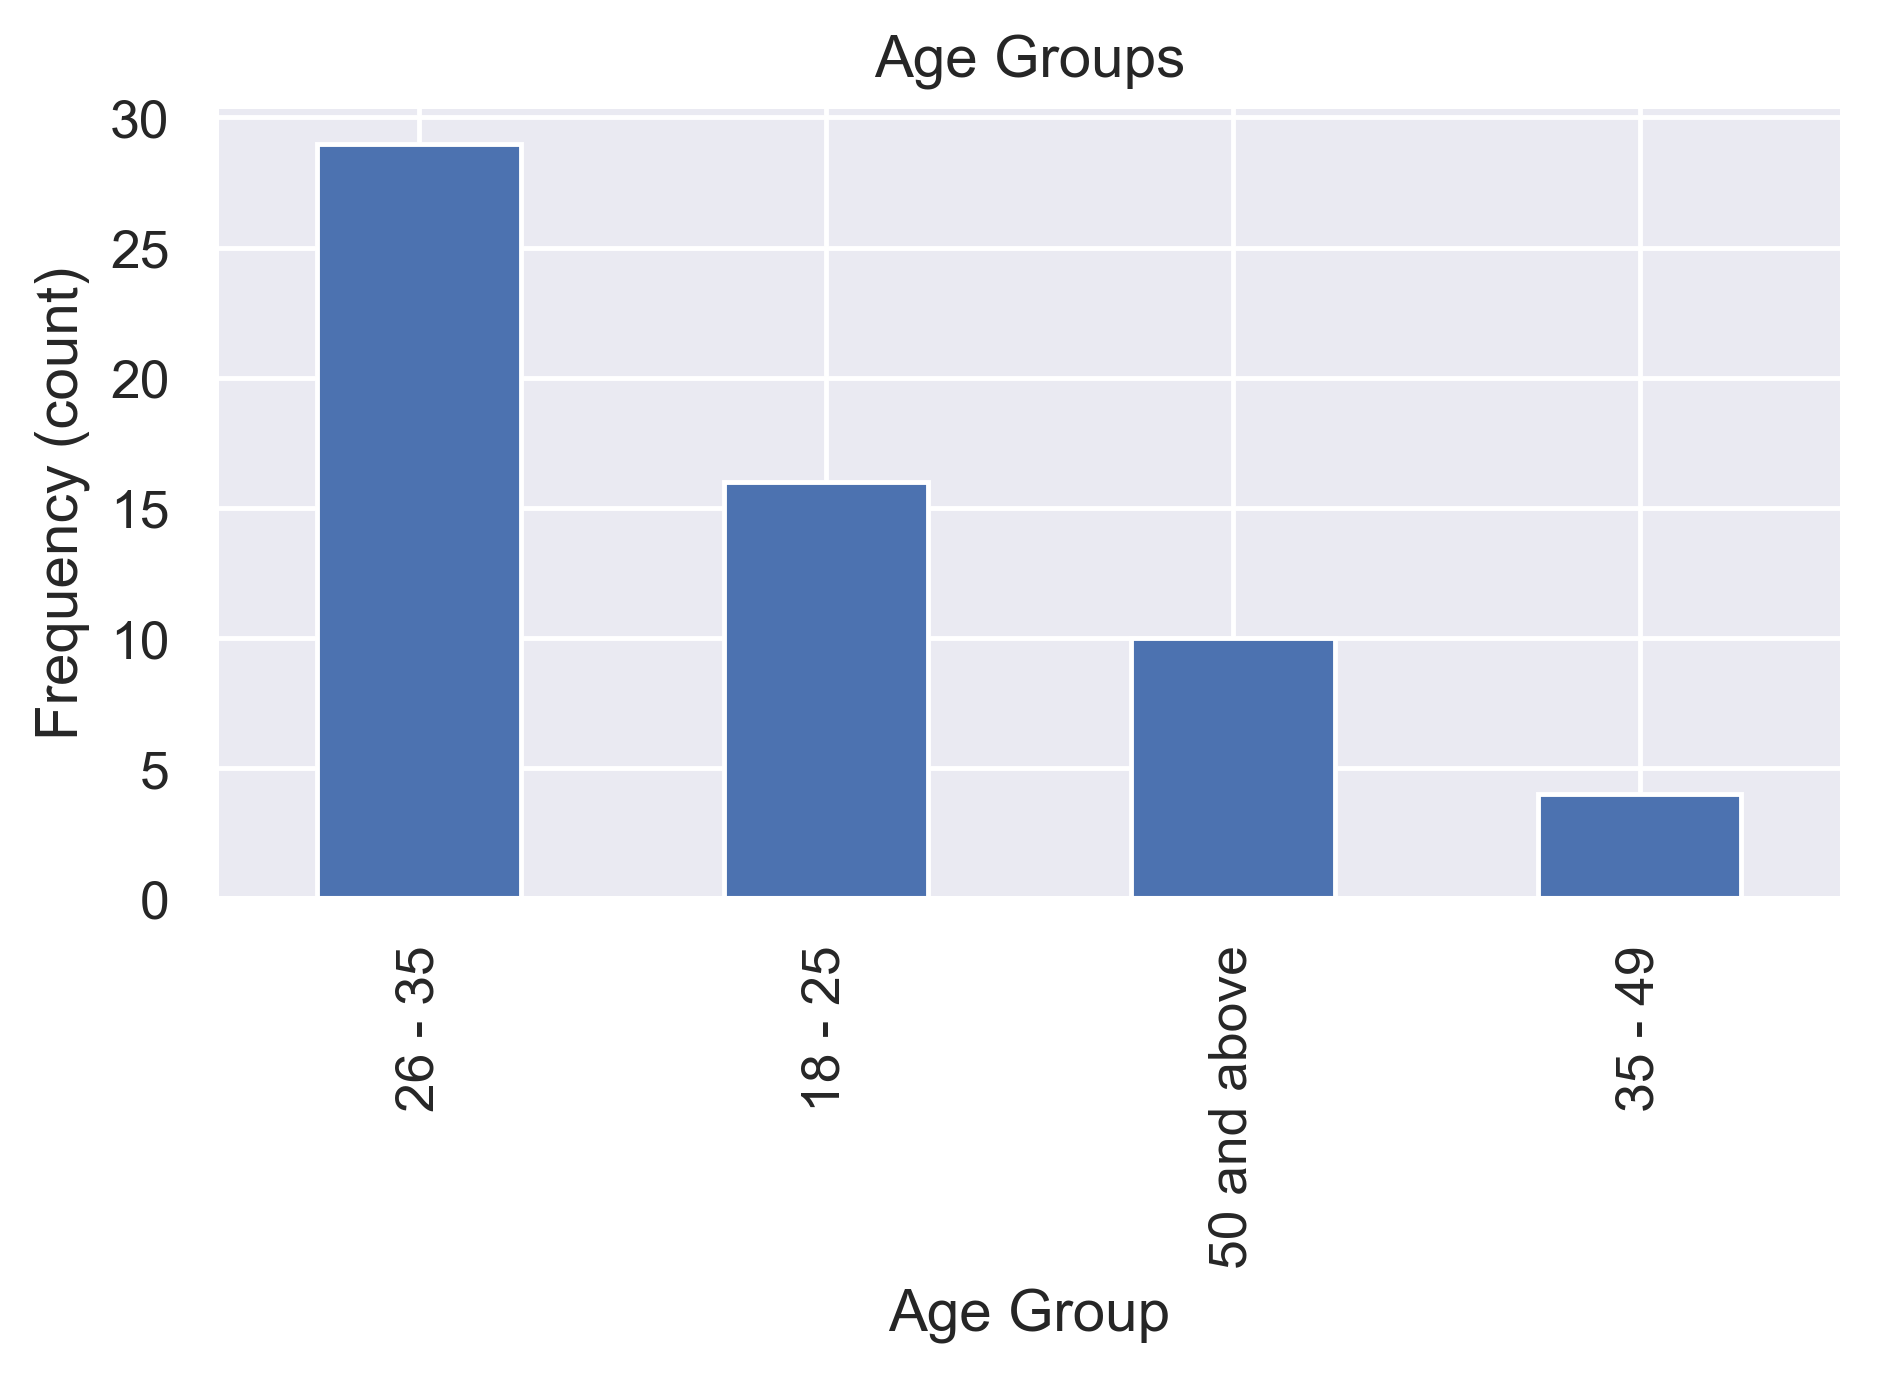

In [17]:
# value counts of 'Age Range'
age_class_value_counts = data['Age Range'].value_counts()

# bar plot of `age_class_value_counts`
age_class_value_counts.plot(
    kind ='bar', 
    xlabel = 'Age Group',
    ylabel = 'Frequency (count)',
    title = 'Age Groups'
);

> Raw count of `Age`

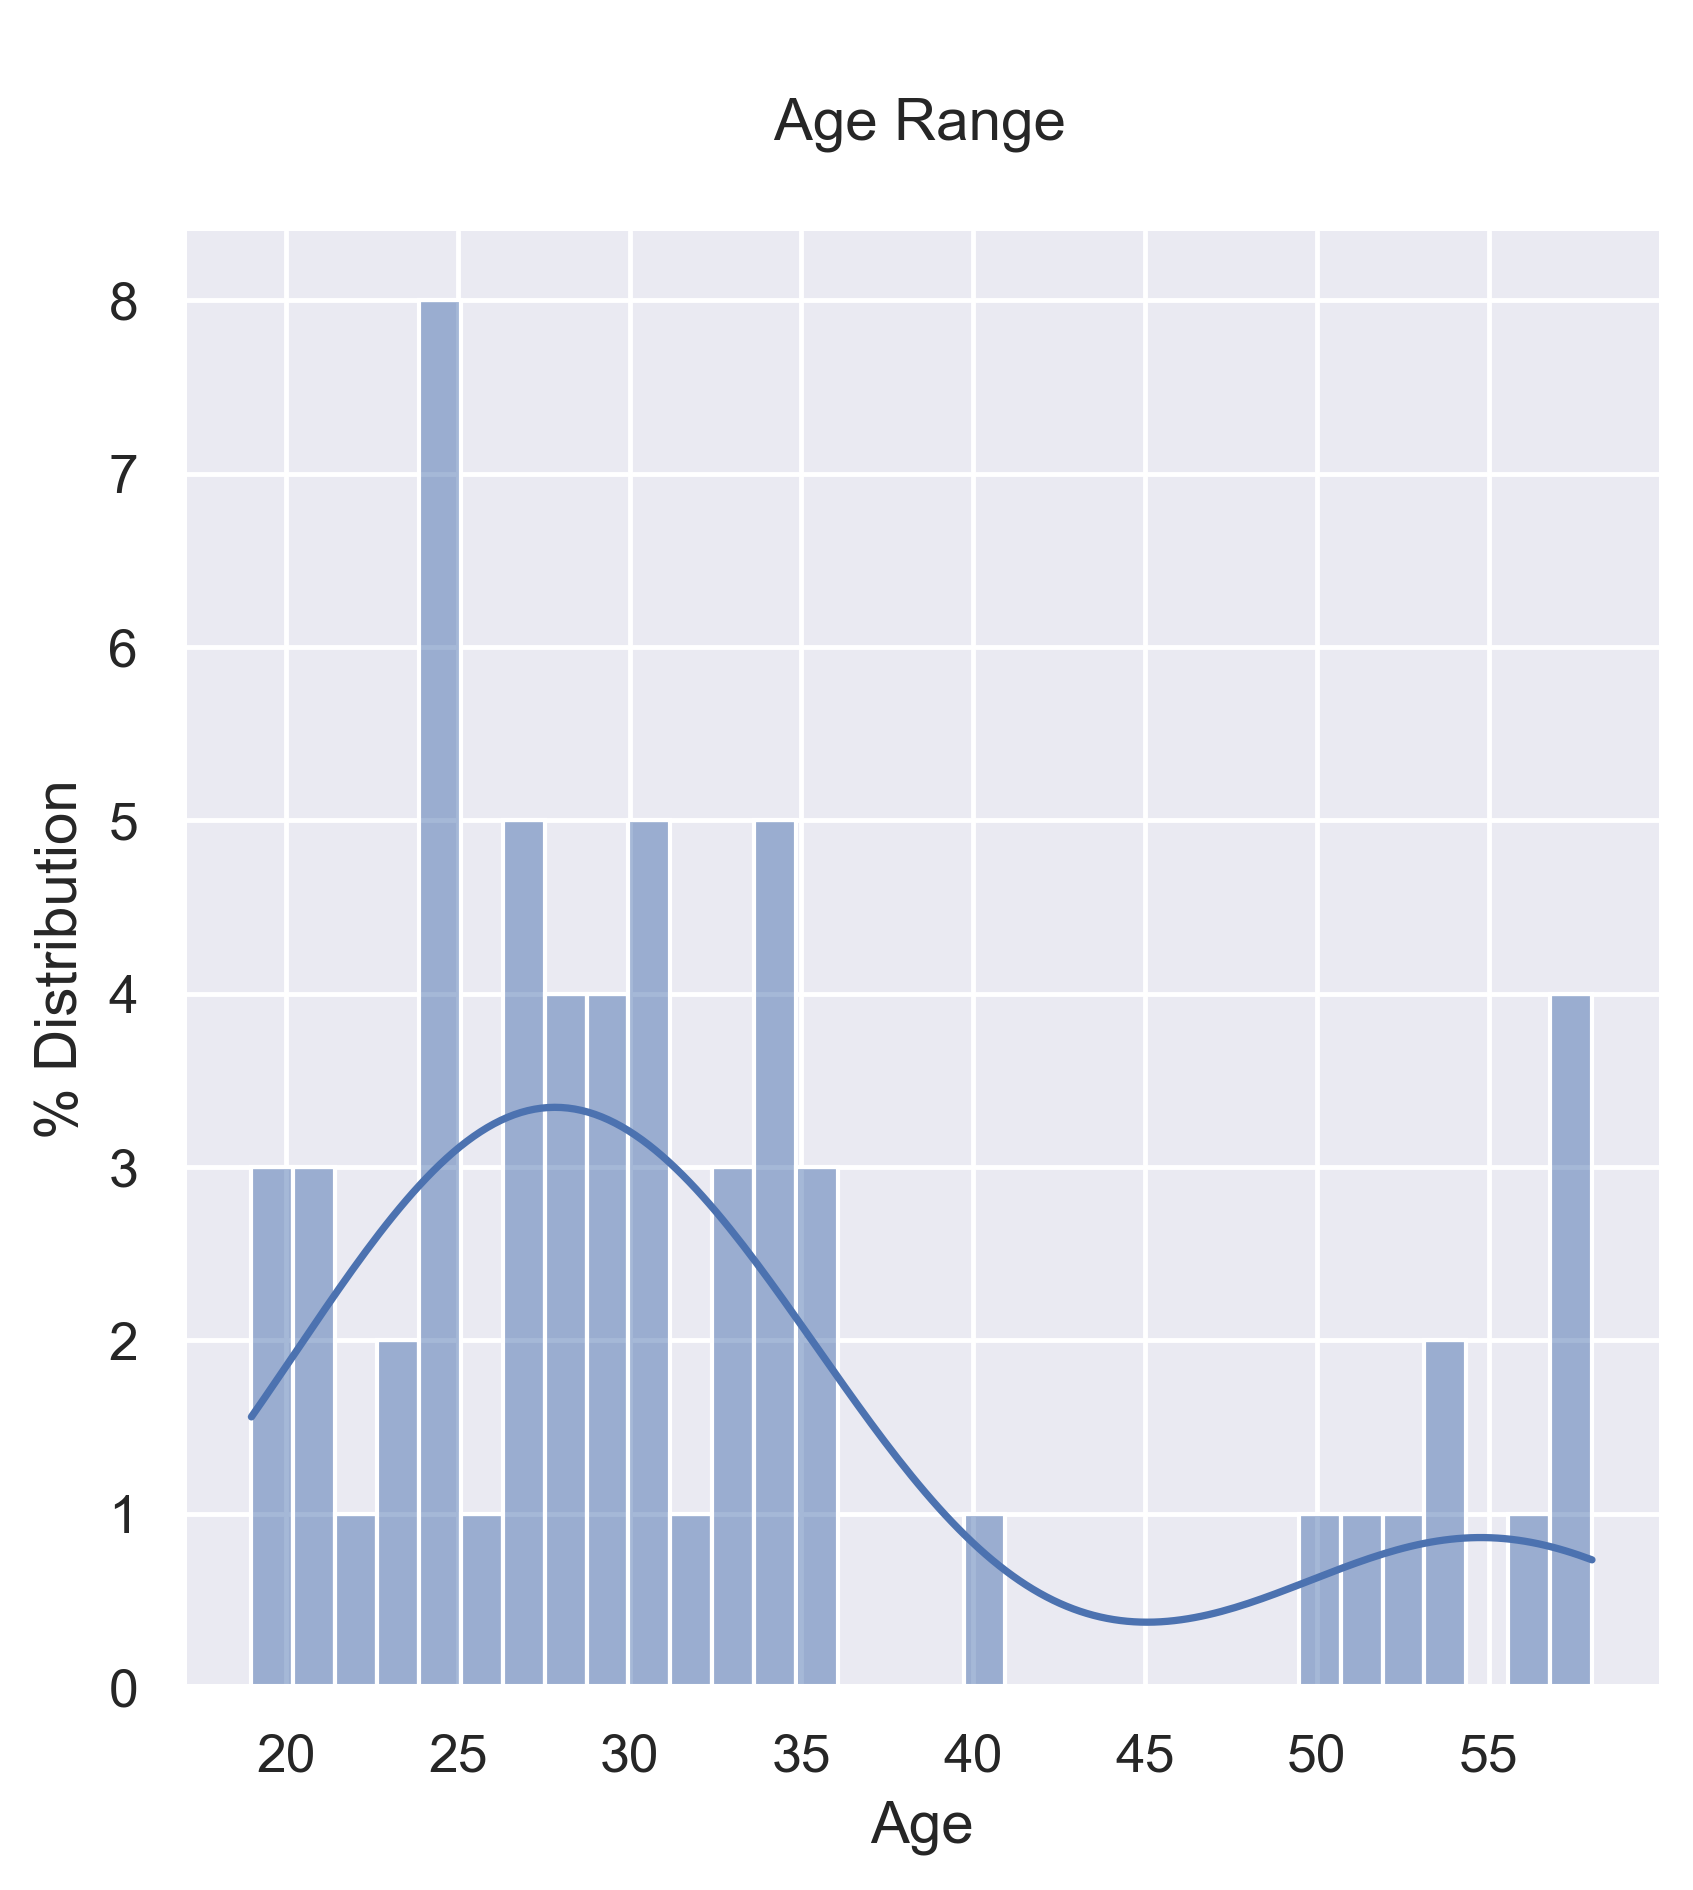

In [18]:
# Density Distribution by Age
ax=sns.displot(data.Age, kde=True, bins=32)
ax.set(xlabel='Age',
      ylabel='% Distribution',
      title='\n Age Range \n');

    There are five age categories, with ages ranging from 18 to well over 50, average age between 26 and 35.
    The predominant age range is actually centered around 24-31 years when we look at the total number of ages.

### Income

> The `Income` brackets

In [19]:
# unique values of 'Monthly Household Income'
income_cat = data['Monthly Household Income'].unique()
print('Income Bracket:', income_cat)

Income Bracket: ['< 50000' '100000 - 200000' '200000 - 500000' '50000 - 100000'
 '> 1000000' '500000 - 1000000']


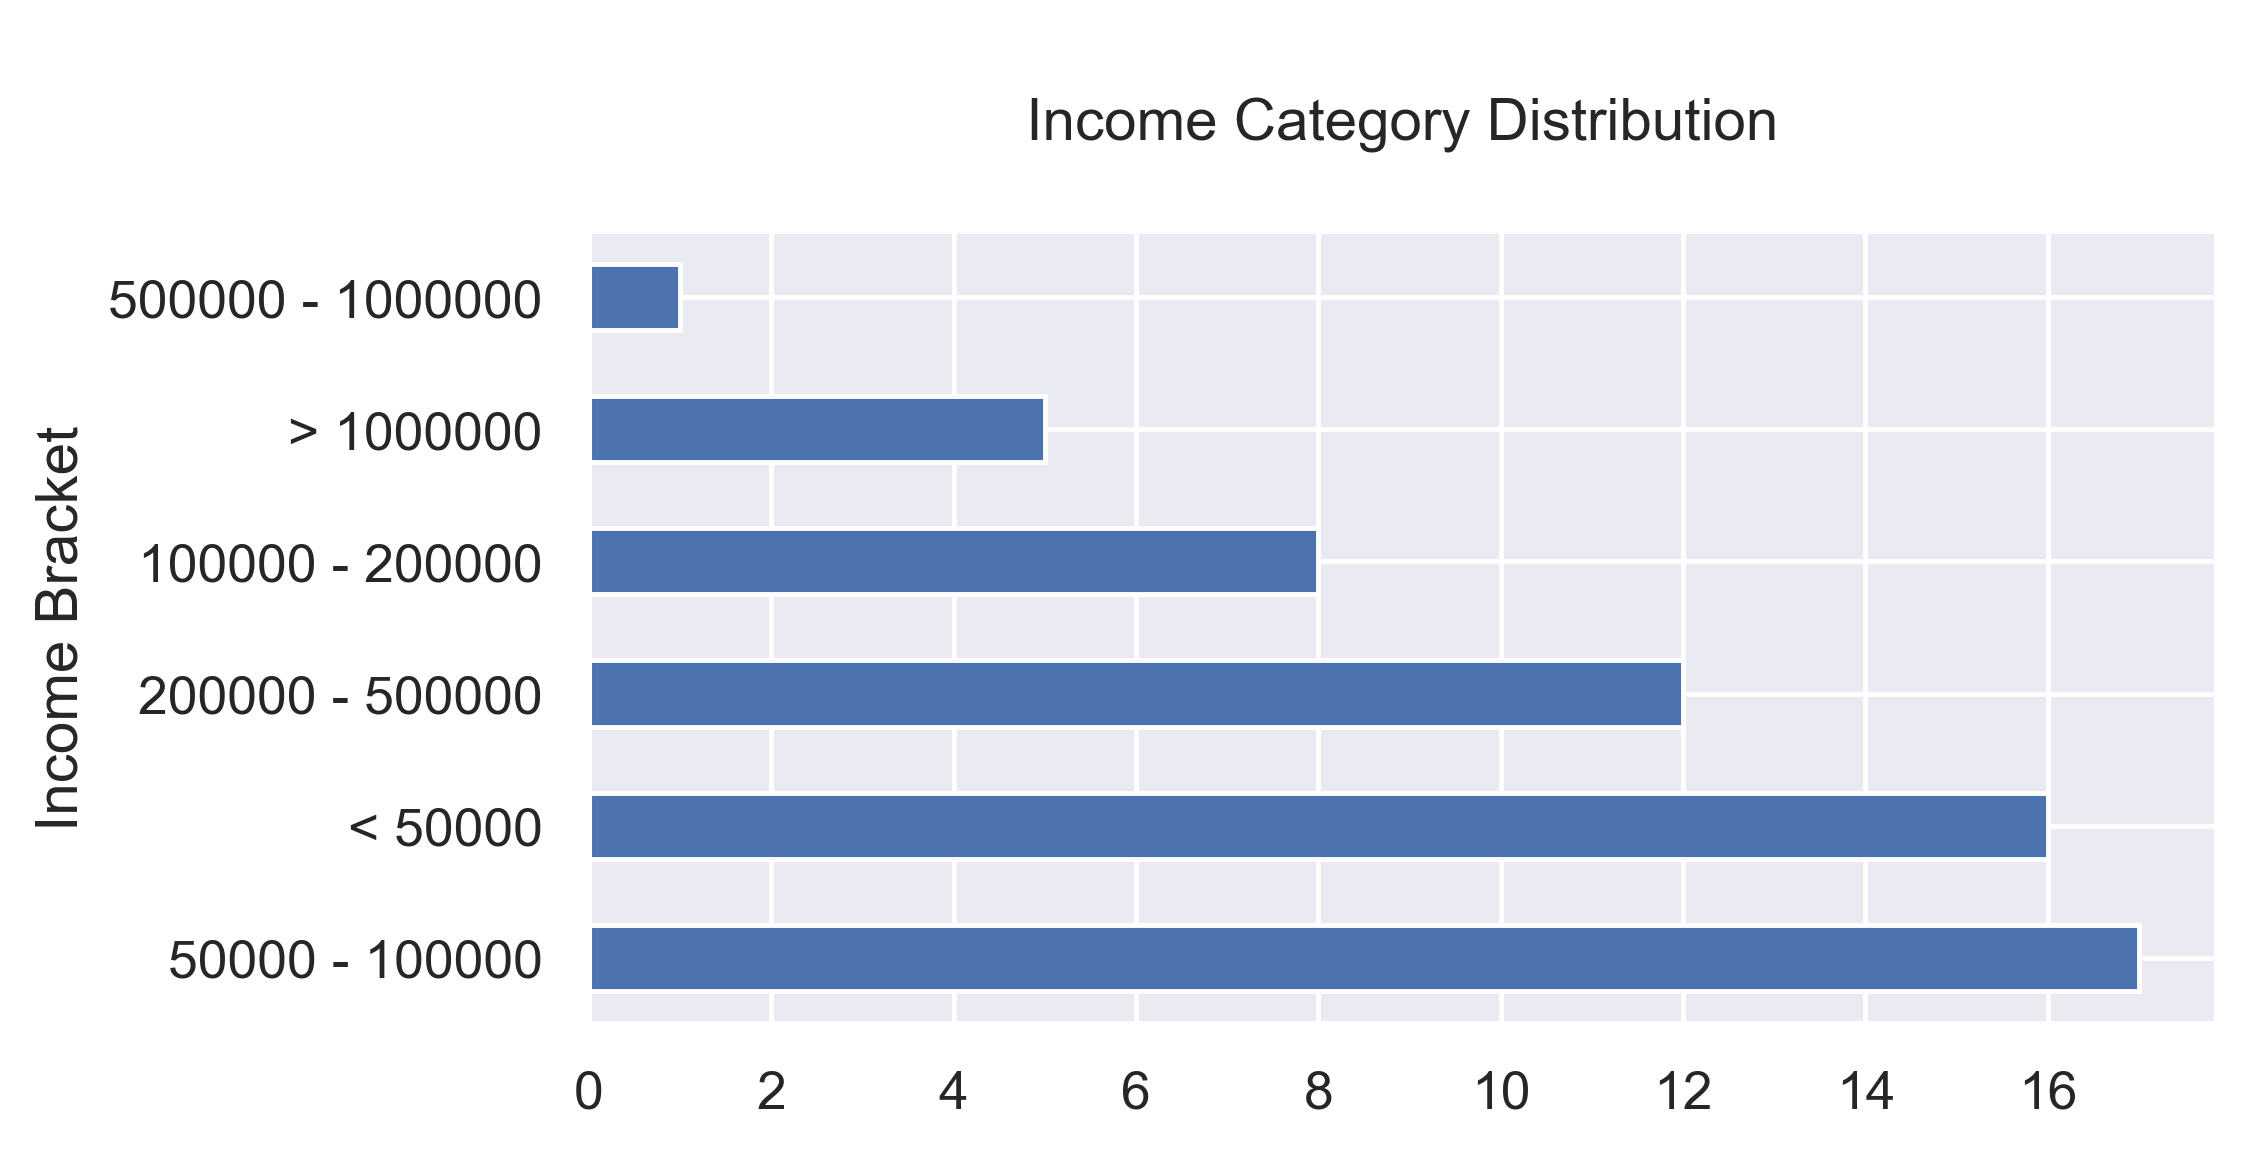

In [20]:
# `household_income_value_counts`
household_income_value_counts = data['Monthly Household Income'].value_counts()
# horizontal bar chart of 'household_income_value_counts'
household_income_value_counts.plot(
    kind ='barh', 
    ylabel = 'Income Bracket',
    title = '\n Income Category Distribution \n'
);

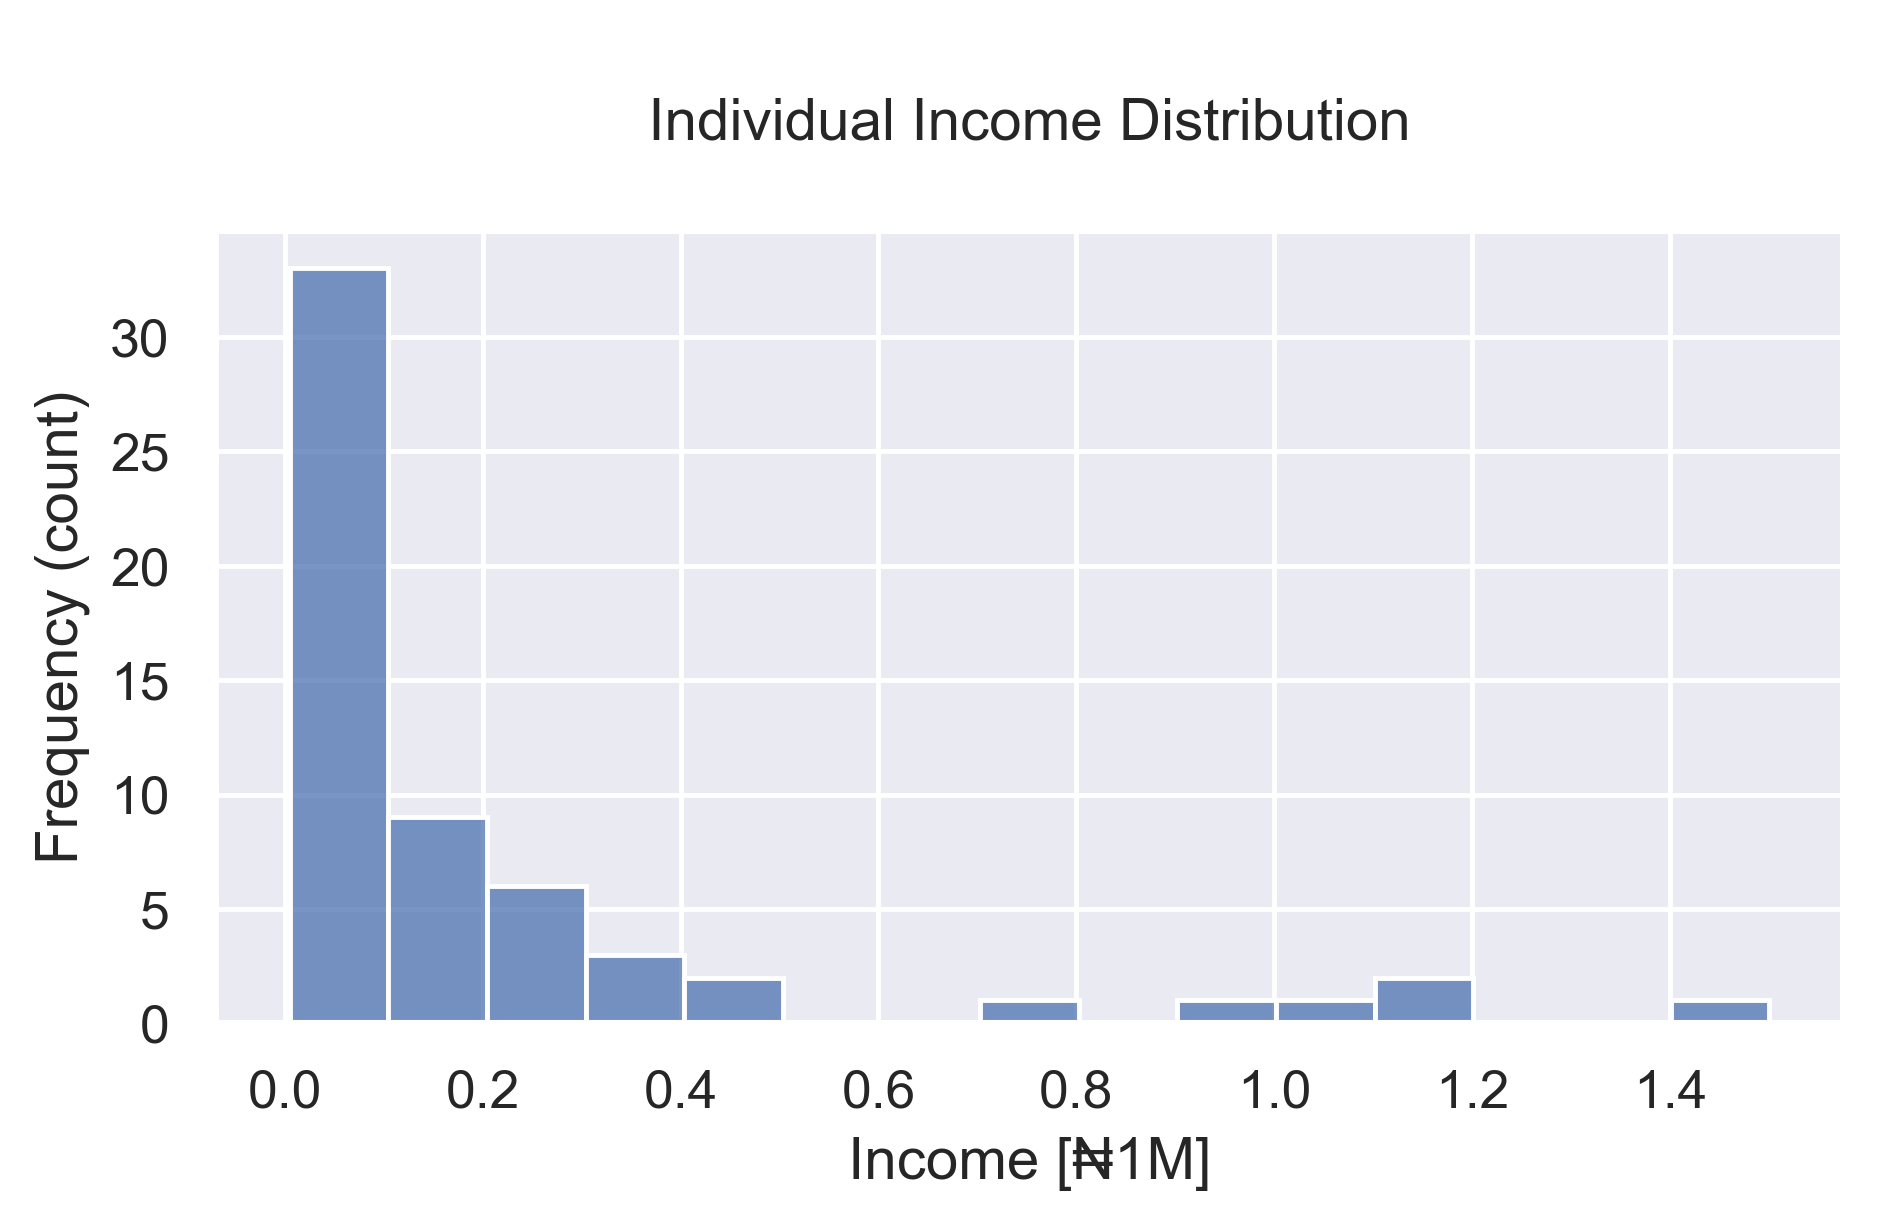

In [21]:
# Distribution of 'Income'
sns.histplot(data['Income']/1e6)
plt.xlabel('Income [₦1M]'),
plt.ylabel('Frequency (count)'),
plt.title('\n Individual Income Distribution \n');

    There are six monthly income levels for households, with the range being below ₦50_000 and above ₦1_000_000. The was between ₦50_000 - ₦100_000. 
    When we examine individual income, the majority of the income is under ₦20_000.

### Occupation

> The different occupations present

In [22]:
# distinct values in 'Occupation'
job_groups = data['Occupation'].unique()
print("Job categories:", job_groups)

Job categories: ['Student' 'Farmer' 'Freelance copywriter' 'Content Creator'
 'Business man' 'Designer' 'Medical Doctor' 'Teacher' 'Nurse'
 'Network marketer' 'Civil servant' 'Researcher' 'Digital marketer'
 'Banker' 'Not Specified' 'CNA' 'Accountant' 'Entrepreneur' 'Unemployed'
 'Butcher' 'Mechanic' 'Assisstant']


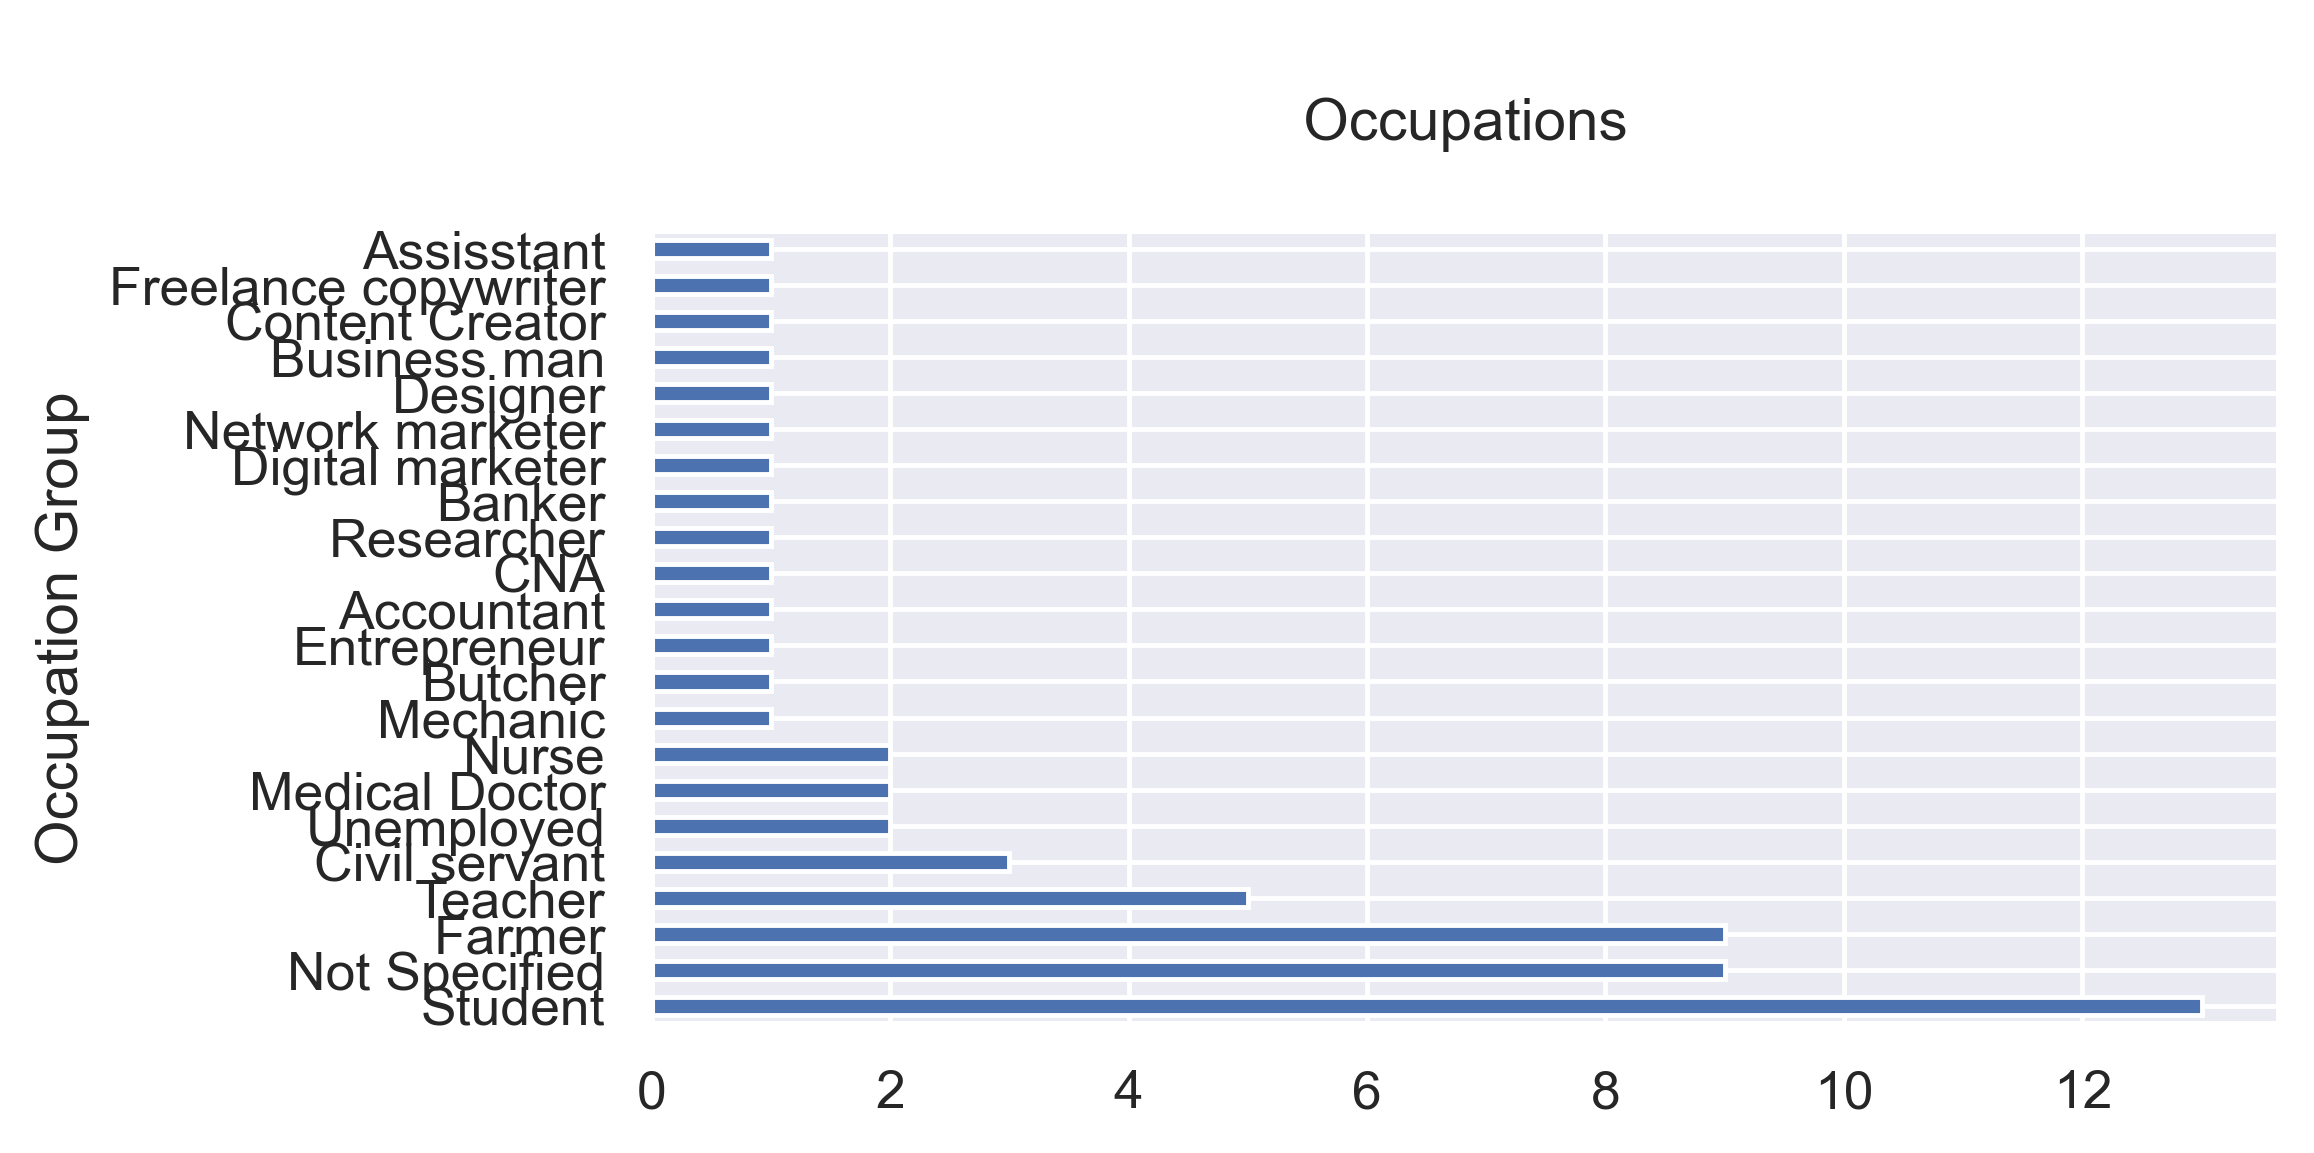

In [23]:
# value counts of 'Occupation'
job_groups_value_counts = data['Occupation'].value_counts()

# horizontal bar plot of `jobs_value_counts`
job_groups_value_counts.plot(
    kind ='barh', 
    xlabel = 'Occupation Group',
    ylabel = 'Frequency (count)',
    title = '\n Occupations \n'
);

    Student was the most frequent profession among the 22 that were recorded.

### Relationship between `Age` and `Income`

- Building an minimal KMeans model with k = 3, to illustrate the relationship between 'Age' and 'Income'

In [24]:
# define features to use
X = data[['Age', 'Income']]
# build model
model = KMeans(n_clusters=3, random_state=42)
# fit model to data
model.fit(X)

KMeans(n_clusters=3, random_state=42)

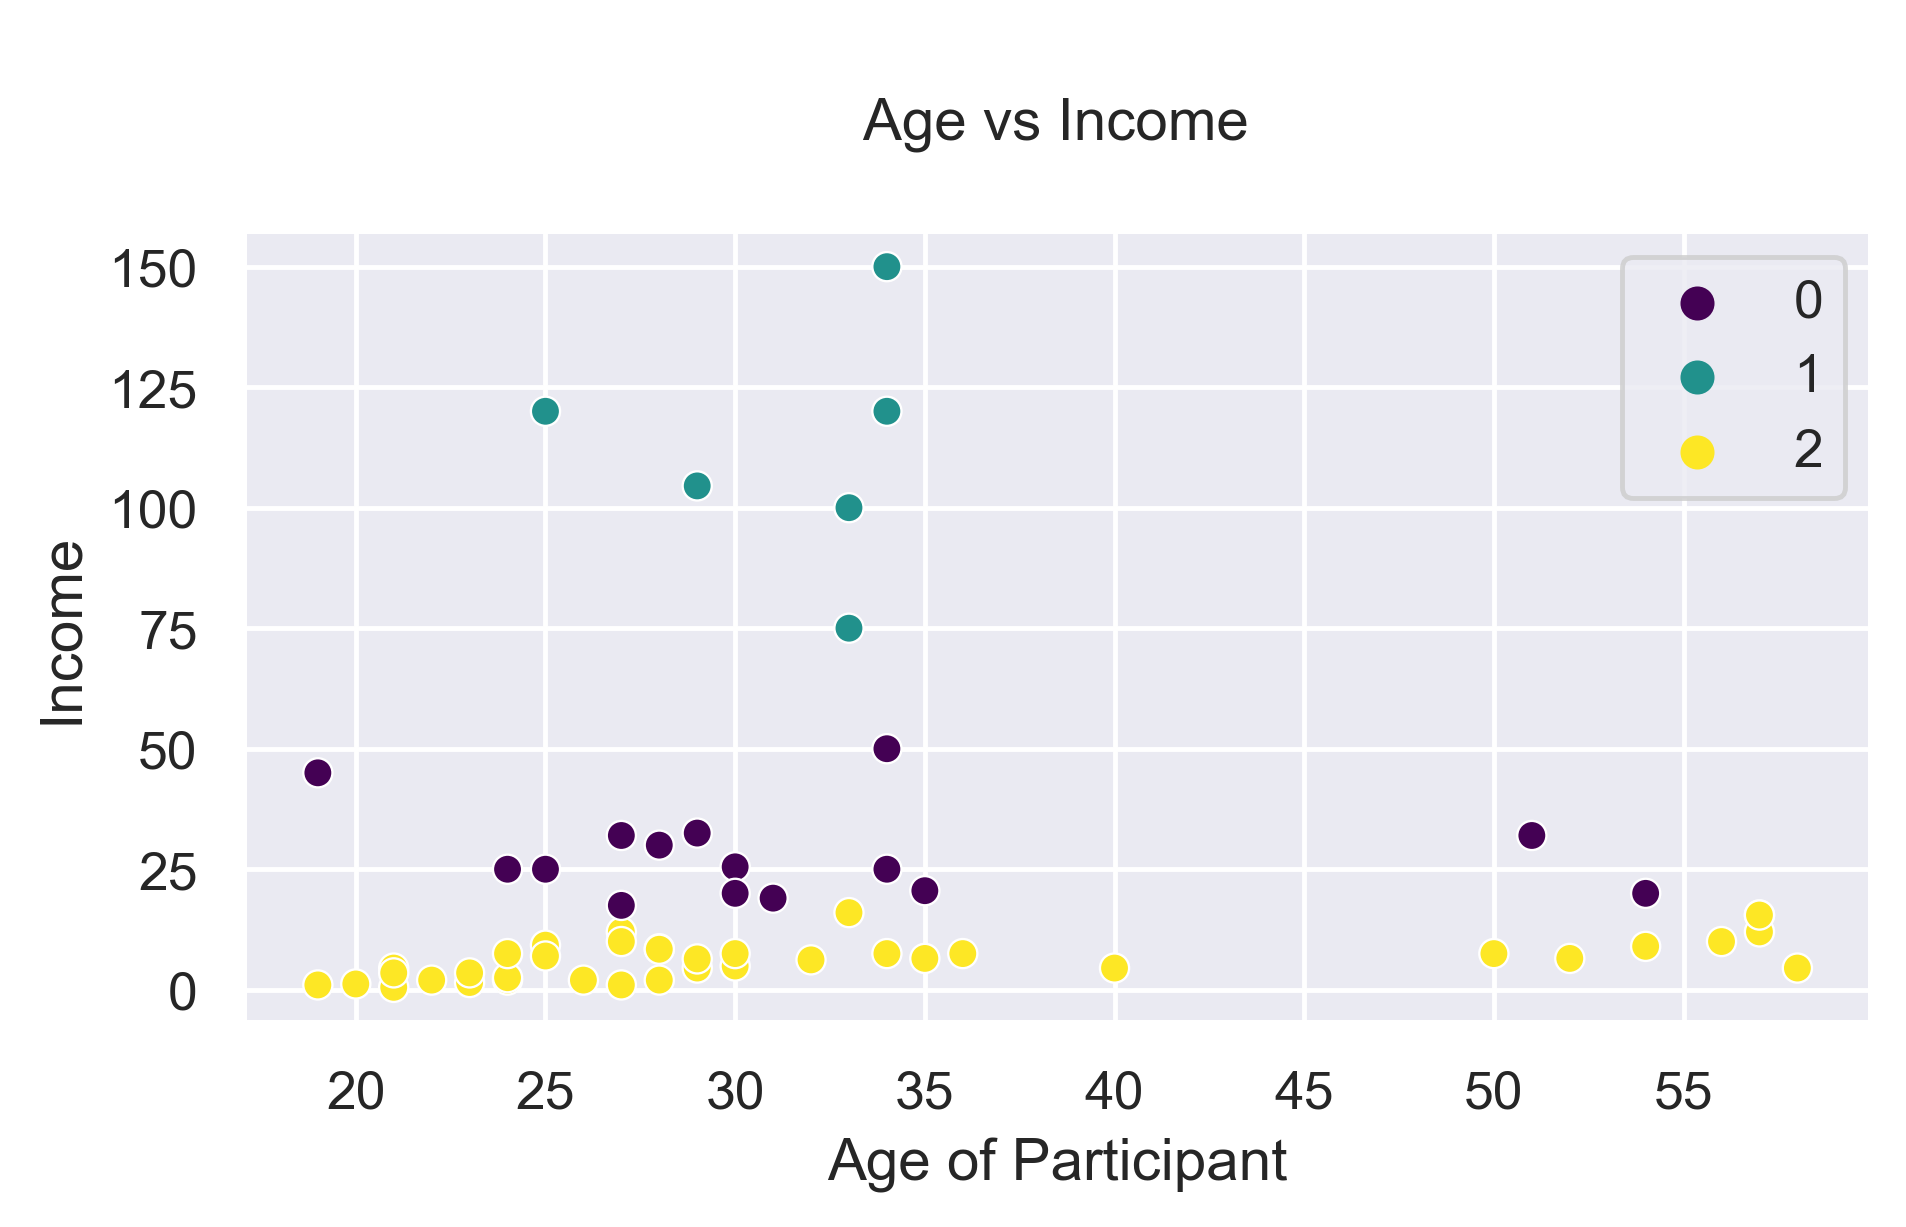

In [25]:
# scatter plot of 'Age' vs 'Income' with hue=label
sns.scatterplot(
    x=data['Age'],
    y=data['Income']/1e4,
    hue=model.labels_,
    palette='viridis'
)
plt.xlabel('Age of Participant')
plt.ylabel('Income')
plt.title('\n Age vs Income \n');

     The 'Age' vs 'Income' scatter plot shows that there is no correlation between the two features.

# Wrangling

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age Range                       59 non-null     object 
 1   Age                             59 non-null     int64  
 2   Gender                          59 non-null     object 
 3   Occupation                      59 non-null     object 
 4   Marital status                  59 non-null     object 
 5   Income                          59 non-null     float64
 6   Monthly Household Income        59 non-null     object 
 7   Location                        59 non-null     object 
 8   Device Type                     59 non-null     object 
 9   Delivery Method                 59 non-null     object 
 10  Farmer                          59 non-null     object 
 11  Farm Produce                    59 non-null     object 
 12  Online Platform                 59 non

- check cardinality

In [27]:
data.nunique()

Age Range                          4
Age                               26
Gender                             2
Occupation                        22
Marital status                     2
Income                            38
Monthly Household Income           6
Location                          13
Device Type                        2
Delivery Method                    4
Farmer                             2
Farm Produce                      51
Online Platform                    3
Alternative Platform Knowledge     3
dtype: int64

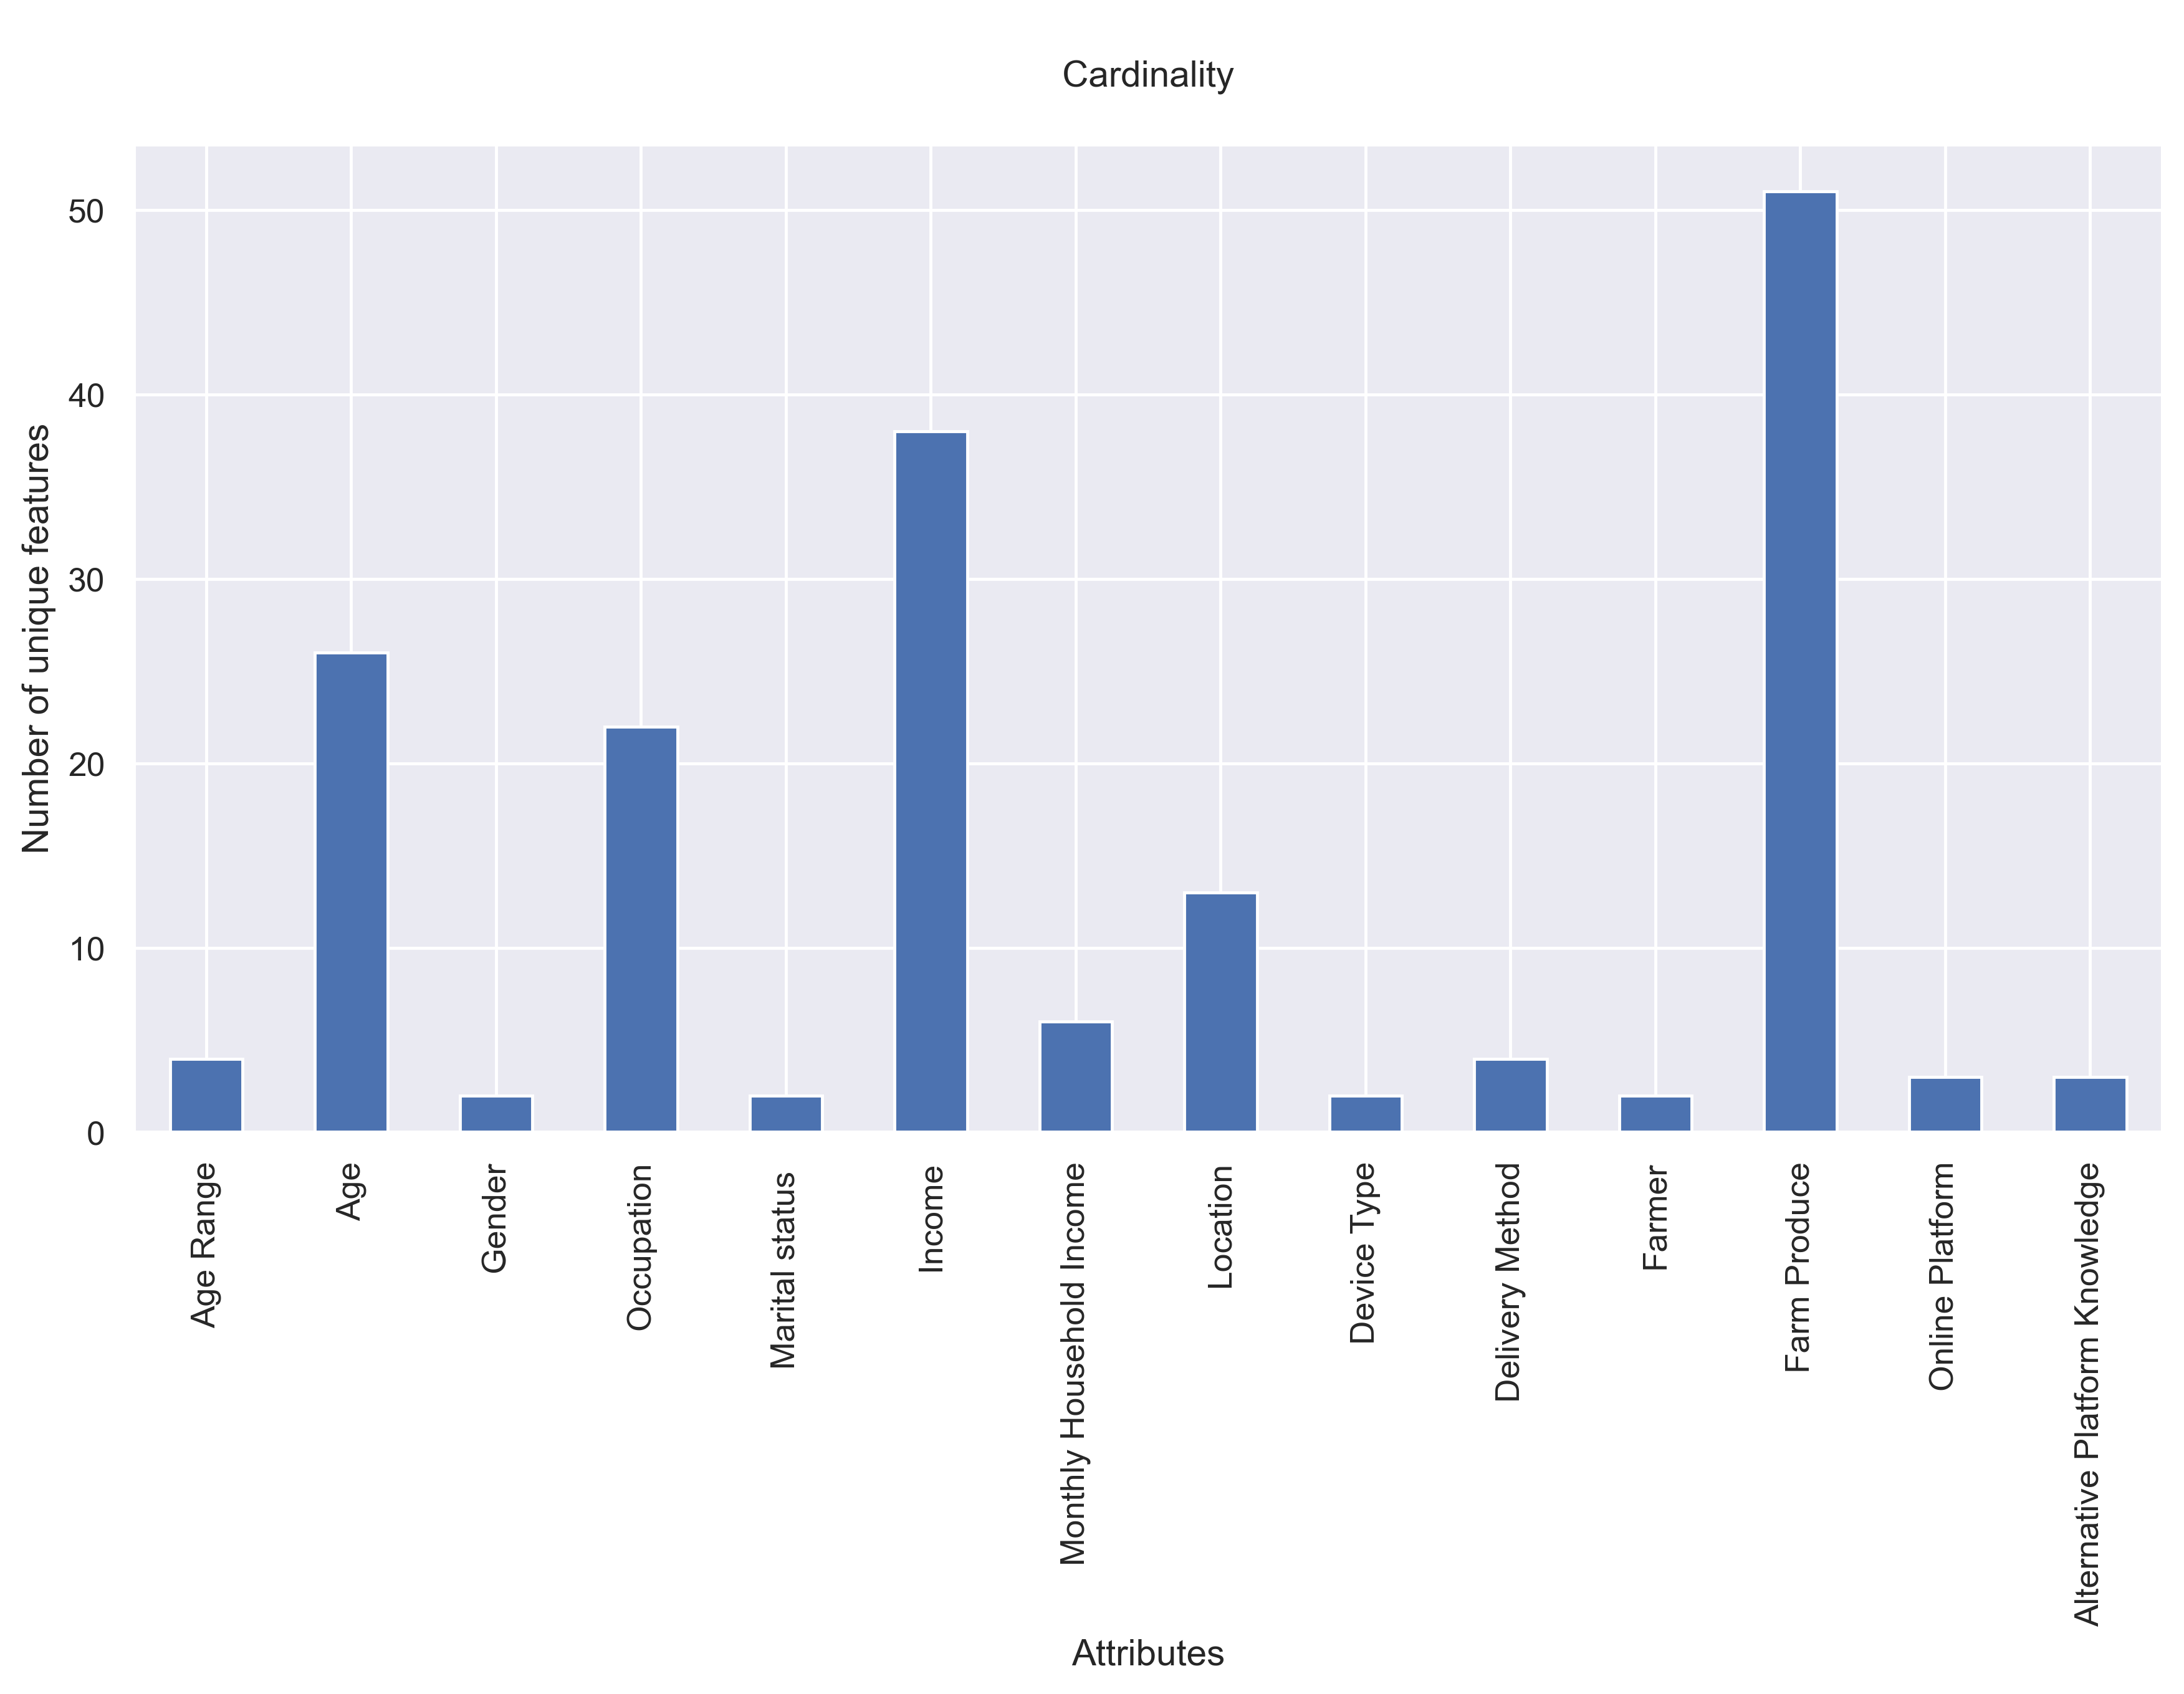

In [28]:
# plot of cardinality
data.nunique().plot.bar(figsize=(12, 6))
plt.xlabel('Attributes')
plt.ylabel('Number of unique features')
plt.title('\n Cardinality \n');

    'Income', 'Age', 'Farm Produce' and 'Occupation' columns had the highest cardinality

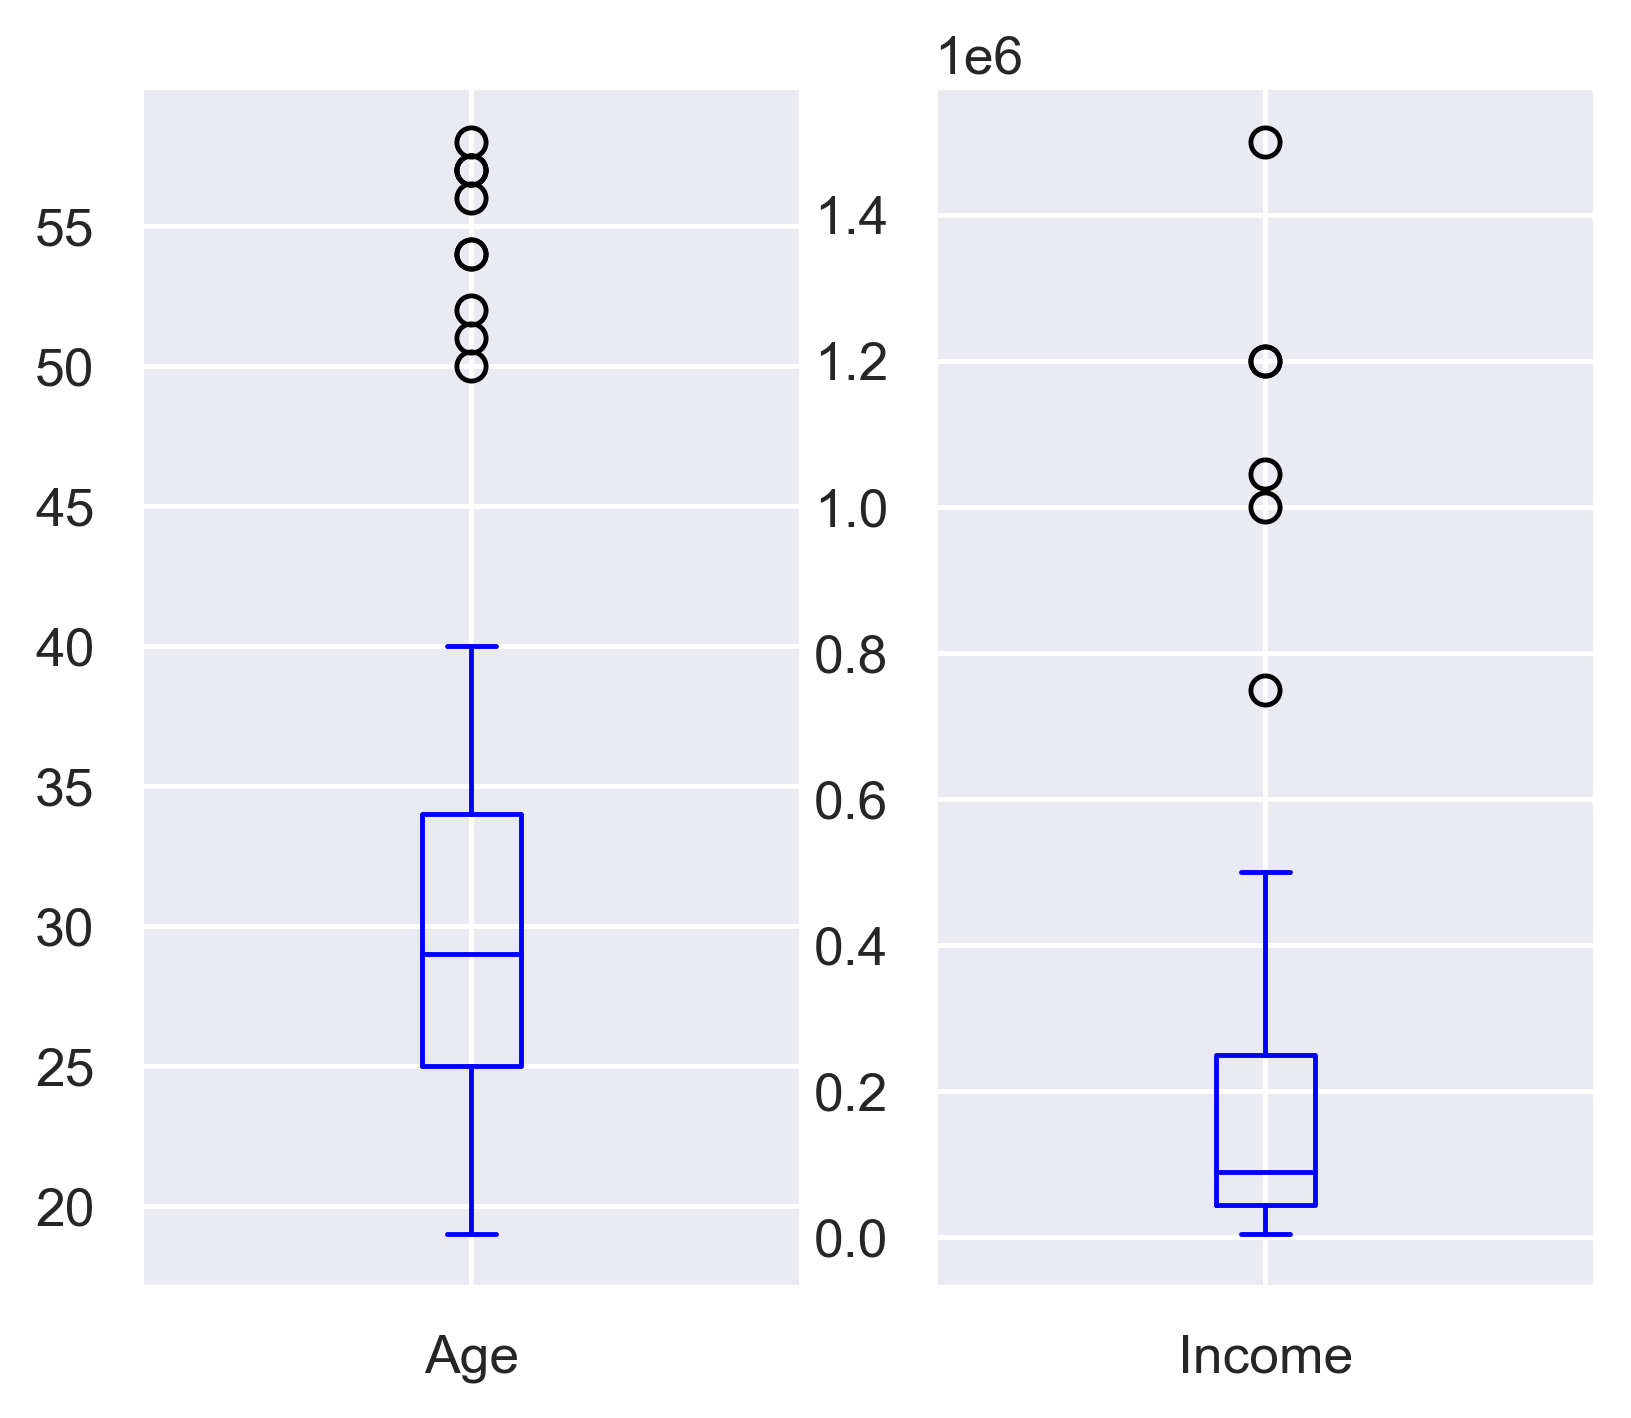

In [29]:
# A look at the outliers
data.plot(kind = 'box', subplots = True, layout=(2, 7),
       sharex= False, sharey= False, figsize=(20,10),
       color='blue');

    This dataset is right-skewed because of the outliers on the right side of the distribution.

In [30]:
# checking the variance
data['Age'].var(), data['Income'].var()

(122.80596142606665, 108582808663.06252)

In [31]:
# trimmed variance
trimmed_var(data['Age']), trimmed_var(data['Income'])

(66.57142857142857, 20106036026.65556)

    The variance increases due to the extreme values in the 'Age' and 'Income' columns, and if we were to trim it,
    it would drop significantly nevertheless we will continue our study without reducing the variance due to the limited
    size of our dataset. We will normalize them instead.

# Building The Model

- Feature seletion

In [32]:
# choosen features
features = ['Age', 'Income', 'Occupation', 'Location']

In [33]:
# making copy of original df
df = data[features].copy()

- Categorical data preprocessing with one hot encoding using dummies

In [34]:
#%pip install kmodes

## Creating KPrototypes

In [35]:
df_norm = df.copy()

In [36]:
scaler = MinMaxScaler()
df_norm[['Age', 'Income']] = scaler.fit_transform(df_norm[['Age', 'Income']])

In [37]:
# importing kmodes
from kmodes.kprototypes import KPrototypes
# instance of KPrototypes using 4 clusters
kproto = KPrototypes(n_clusters=4, init='Cao')
# fit model and predict
clusters = kproto.fit_predict(df_norm, categorical=[2, 3])
#join data with labels
labels = pd.DataFrame(clusters)
labeledCustomers = pd.concat((df, labels), axis=1)
labeledCustomers = labeledCustomers.rename({0: 'labels'}, axis=1)

In [38]:
# look at df head
labeledCustomers.head()

Age    Income            Occupation  Location  labels
0   21    5000.0               Student  Modakeke       1
1   27  120000.0               Student      Osun       1
2   57  155000.0                Farmer      Osun       0
3   23   15000.0               Student     Ekiti       1
4   28  300000.0  Freelance copywriter    Ibadan       3

> KMeans, **One Hot Encoding**

In [39]:
# getting dummies for the categorical features
df_norm = pd.get_dummies(df_norm, columns=['Occupation','Location'])
df_norm.head()

Age    Income  Occupation_Accountant  Occupation_Assisstant  \
0  0.051282  0.000000                      0                      0   
1  0.205128  0.076923                      0                      0   
2  0.974359  0.100334                      0                      0   
3  0.102564  0.006689                      0                      0   
4  0.230769  0.197324                      0                      0   

   Occupation_Banker  Occupation_Business man  Occupation_Butcher  \
0                  0                        0                   0   
1                  0                        0                   0   
2                  0                        0                   0   
3                  0                        0                   0   
4                  0                        0                   0   

   Occupation_CNA  Occupation_Civil servant  Occupation_Content Creator  ...  \
0               0                         0                           0  ...   
1               0                         0                           0  ...   
2               0                         0                           0  ...   
3               0                         0                           0  ...   
4               0                         0                           0  ...   

   Location_Ekiti  Location_Ibadan  Location_Ife  Location_Lagos  \
0               0                0             0               0   
1               0                0             0               0   
2               0                0             0               0   
3               1                0             0               0   
4               0                1             0               0   

   Location_Lagos   Location_Modakeke  Location_Modakeke   Location_Osun  \
0                0                  1                   0              0   
1                0                  0                   0              1   
2                0                  0                   0              1   
3                0                  0                   0              0   
4                0                  0                   0              0   

   Location_Osun   Location_Oyo  
0               0             0  
1               0             0  
2               0             0  
3               0             0  
4               0             0  

[5 rows x 37 columns]

> Cluster Optimization using **Inertia** and **Silhoutte Score**

In [40]:
# initialization
# iterate from k = 2 including or up 9
n_clusters = range(2, 10)
inertia_errors = []
silhouette_scores = []

# adding `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    # build model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    # train model
    model.fit(df_norm)
    # calculate inertia
    inertia_errors.append(model.named_steps['kmeans'].inertia_)
    # calculate silhoutte score
    silhouette_scores.append(
        silhouette_score(df_norm, model.named_steps['kmeans'].labels_)
    )
    
print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [2066.6938001675558, 1988.7006149454878, 1899.945560906428]

Silhouette Scores: [0.12138099181596249, 0.12657860927436898, 0.1257340060204681]


> Line plot of **Inertia**

In [41]:
# line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x = n_clusters,
    y = inertia_errors,
    title = 'KMeans Model: Inertia vs Number of Clusters'
)

fig.update_layout(
    xaxis_title = 'Number of Clusters',
    yaxis_title='Inertia'
)

fig.show()

      The plot is not very clear however, we can see a change in point on k = 5.

 > Line plot of **Silhoutte Score**

In [42]:
# line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x= n_clusters,
    y= silhouette_scores,
    title= 'K-Means Model: Silhouette Score vs Number of Clusters'
)
fig.update_layout(
    xaxis_title= 'Number of Clusters (k)',
    yaxis_title= 'Silhouette Score'
)
fig.show()

    The graph shows that number of clusters are 6.

## Building The Final KMeans Model (with k=6)

In [43]:
# instance of KMeans
kmeans = KMeans(n_clusters=6)
# fit and predict
clusters = kmeans.fit_predict(df_norm)
labels = pd.DataFrame(clusters)
labeledCustomers = pd.concat((df, labels), axis=1)
labeledCustomers = labeledCustomers.rename({0: 'labels'}, axis=1)

- The predicted clusters

In [44]:
X = pd.DataFrame(labeledCustomers)
X.head()

Age    Income            Occupation  Location  labels
0   21    5000.0               Student  Modakeke       0
1   27  120000.0               Student      Osun       0
2   57  155000.0                Farmer      Osun       4
3   23   15000.0               Student     Ekiti       0
4   28  300000.0  Freelance copywriter    Ibadan       1

    We can see that the model put the participants in different 6 subgroups according to the 4 features given.

## Dimensionality Reduction

### Building a PCA model

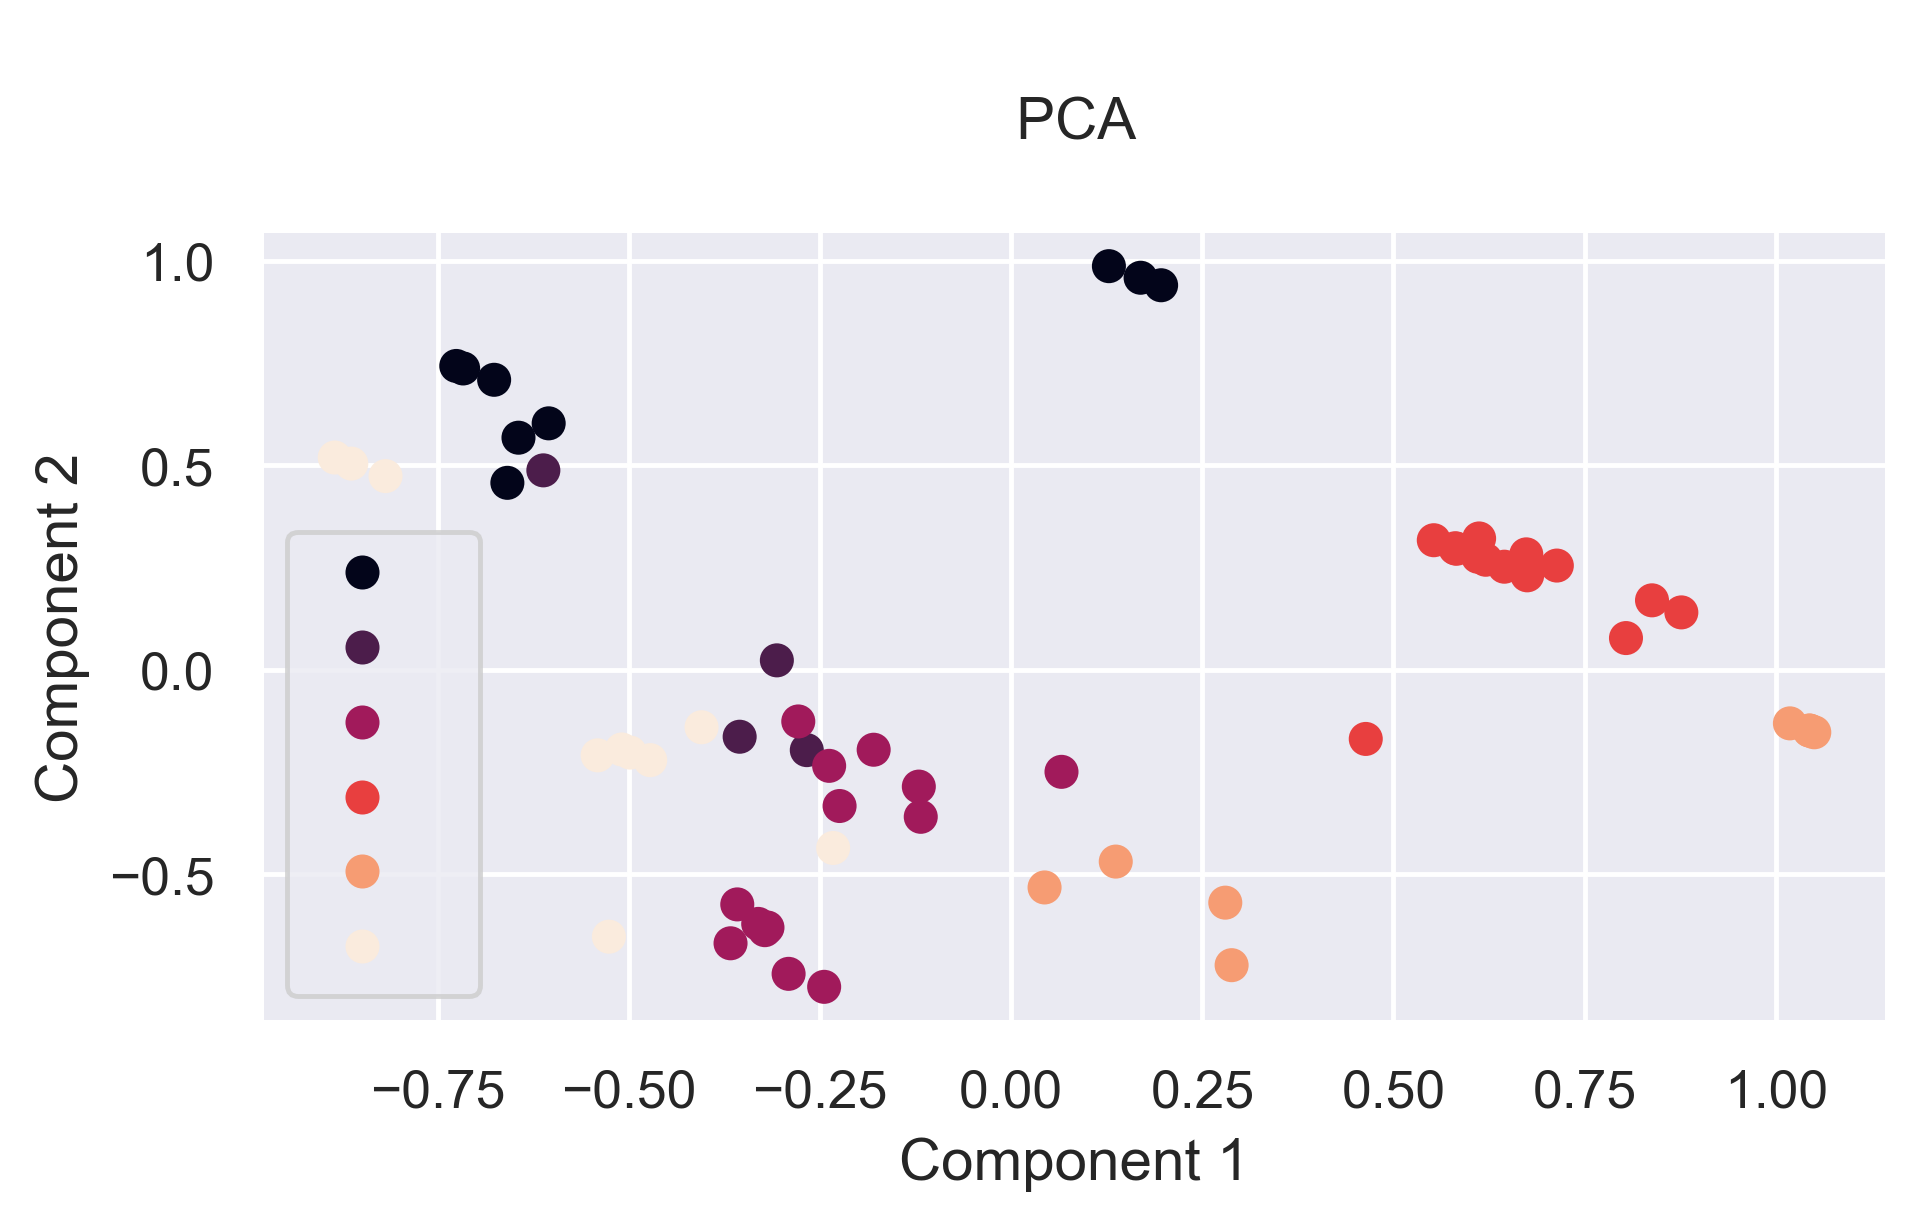

In [45]:
# instantiate transformer
pca = PCA(n_components=2, random_state=42)
# transform `X`
X_t = pca.fit_transform(df_norm)
# make scatter plot of clusters
plot = plt.scatter(X_t[:,0], X_t[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('\n PCA \n')
plt.show();

In [46]:
X_t[:3]

array([[-0.64451867,  0.56732105],
       [ 0.19606953,  0.94000028],
       [ 1.04472557, -0.14885578]])

       The value of -0.63 is the score of Component 1. This value tells us that a certain feature has a slightly high
       inverse influence on the Principal Component 1.
    The **bi plot** shows how the features influence the components in terms of impportance. 

In [47]:
import numpy as np
# 10 samples with 4 features
train_features = np.random.rand(10,4)

model = PCA(n_components=2).fit(train_features)
X_pc = model.transform(train_features)
# n components
n_pcs = model.components_.shape[0]
# get index of most important feature on each component
most_imp = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feat_names = ['Age', 'Income', 'Occupation', 'Location']
# get names
most_imp_names = [initial_feat_names[most_imp[i]] for i in range(n_pcs)]

dict = {'PC{}'.format(i): most_imp_names[i] for i in range(n_pcs)}
# dataframe
pca_df = pd.DataFrame(dict.items())
pca_df

0       1
0  PC0  Income
1  PC1     Age

    On PC1 'Income' is more important and on PC2 the feature is 'Occupation.

# Summary

The survey respondents' replies varied, as seen in the analysis above, and we developed a model from those responses that divided them into 6 subgroups based on their financial and demographic characteristics. More information is required to build a more compelling argument.

# References

- 1.Data dictionary source code, 
https://github.com/p-easter/Python_DataDictionary/blob/main/README.md
- 2. PCA explaination, https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components

In [54]:
data_d = pd.read_csv('data_dictionary.csv')
data_d

Type  Length                                        Description
0    object      59  The upper and lower ages, grouped as '18-25', ...
1     int64      59       An individual's age between 18 and above 50.
2    object      59  The social constructed identity of men and wom...
3    object      59                            The type of profession.
4    object      59                 The legally defined marital state.
5   float64      59  The money received on a regular basis, in Nige...
6    object      59  The combined income per household on a monthly...
7    object      59  The place of residence of the participant with...
8    object      59  The type of mobile device(s) the participant u...
9    object      59    The mode of delivery of farm produce preferred.
10   object      59  An individual who owns a farm or sells produce...
11   object      59  Crops and other agricultural products(includin...
12   object      59  An online platform where consumers and farmers...
13   object      59  Knowledge of other competitive online farmer's...
14   object      59  Features that the user would like to see on a ...

- Saving trained model

In [49]:
import pickle

In [50]:
# saving kmeans model
filename = 'customer_model_1.sav'
pickle.dump(model, open(filename, 'wb'))

In [51]:
# loading saved model
loaded_model = pickle.load(open('customer_model_1.sav', 'rb'))

In [52]:
#X = pd.DataFrame(labeledCustomers)
#X.head()

In [53]:
# print columns present in dataset
for column in X.columns:
    print(column)

Age
Income
Occupation
Location
labels
